In [97]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [115]:
from research.strings import INSPECTION_ID, DATE, TARGET, PREDICTORS, OTHER_PREDICTORS
from research.evaluation import evaluate_model, show_roc, show_prc
from research.metrics import to_inspection_daynum, show_metrics, compare_metrics
from research.utils import get_crit_mat

In [4]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
model_ids = [
    "1553028756",
    "1553029949",
    "1553029430",
    "1553030150",
    "1553029532",
]

In [5]:
models = [load_model("models/model_{}.h5".format(mid)) for mid in model_ids]

In [7]:
SPLIT_DATE = 16252
d_all = pd.read_csv("data/inspections.csv")
d_train = d_all.query("{} <= {}".format(DATE, SPLIT_DATE))
d_test = d_all.query("{} > {}".format(DATE, SPLIT_DATE))
crit_train = get_crit_mat(d_train)
crit_test = get_crit_mat(d_test)
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]
y_train = d_train[TARGET]
y_test = d_test[TARGET]

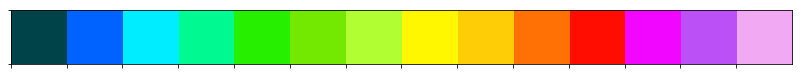

In [55]:
sns.palplot(sns.color_palette("gist_ncar", 14))

In [54]:
def plot_output_dists(models, model_ids, X, name):
    pal = sns.color_palette("gist_ncar", 14)
    fig, axes = plt.subplots(2, 3)
    axes = axes.flatten()
    for mid, model, ax in zip(model_ids, models, axes):
        preds = model.predict(X)
        for i, (v, color) in enumerate(zip(range(1, 15), pal)):
            sns.distplot(preds[:,i], kde=False, color=color, label="V{}".format(v), ax=ax)
            ax.set_title("Model {}".format(mid))
    axes[-1].axis("off")
    axes[0].legend(bbox_to_anchor=(3.25, -0.35), ncol=3, frameon=False)
    fig.set_size_inches(14, 6)
    fig.suptitle("Violation Output Distributions ({})".format(name))
    plt.subplots_adjust(hspace=0.3)
    plt.show()

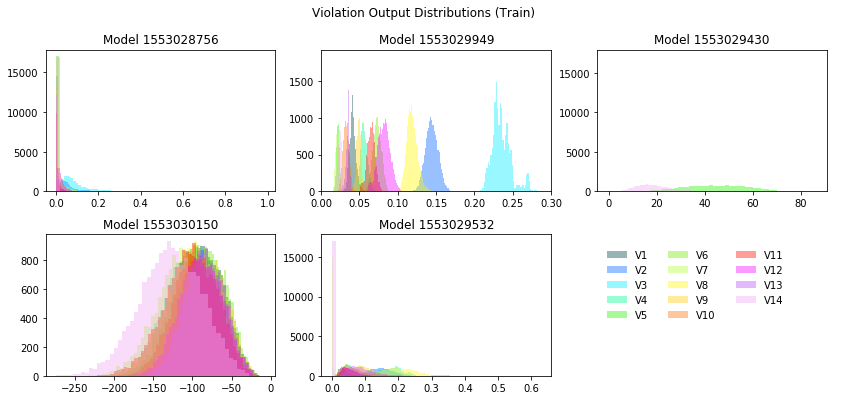

In [56]:
plot_output_dists(models, model_ids, X_train, "Train")

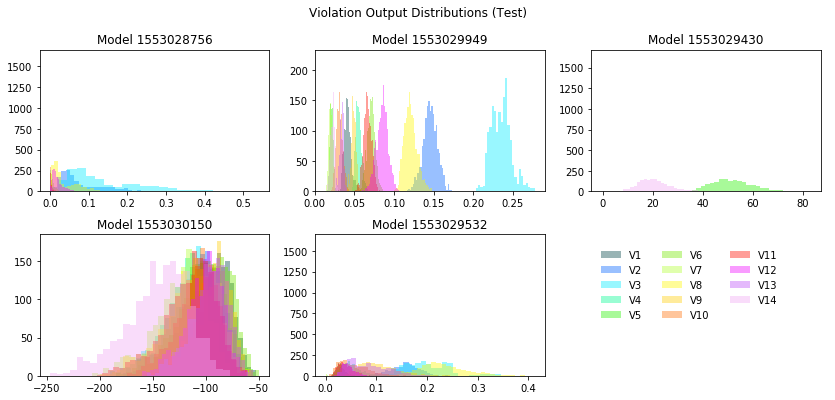

In [57]:
plot_output_dists(models, model_ids, X_test, "Test")

In [95]:
def predict_z(model, X_train, X_test):
    mus = model.predict(X_train).mean(axis=0)
    sigmas = model.predict(X_train).std(axis=0) + 1e-5
    zs = ((model.predict(X_test) - mus) / sigmas)
    return zs

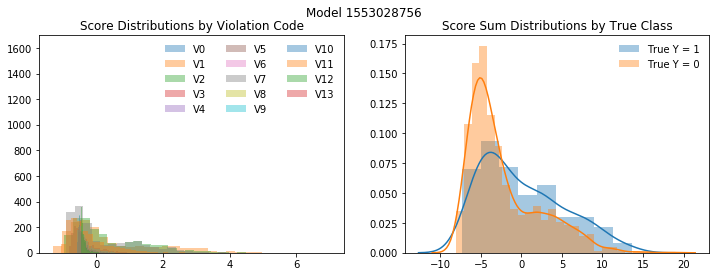

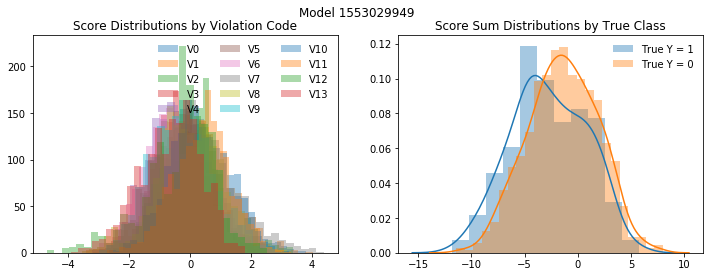

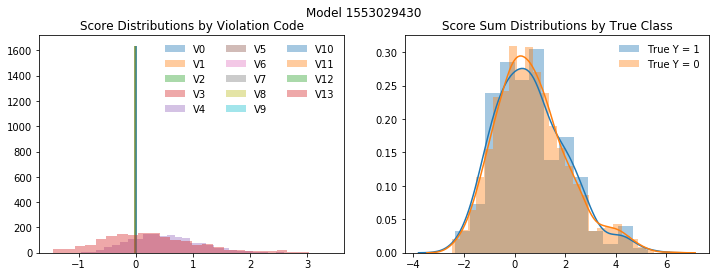

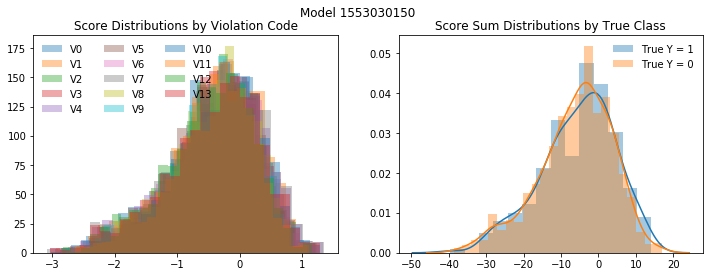

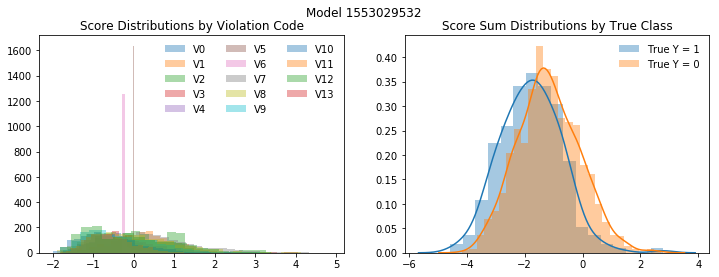

In [96]:
X_test_pos = d_test.query("{} > 0".format(TARGET))[PREDICTORS]
X_test_neg = d_test.query("{} == 0".format(TARGET))[PREDICTORS]
for model, mid in zip(models, model_ids):
    zs = predict_z(model, X_train, X_test)
    fig, axes = plt.subplots(1, 2)
    for i in range(14):
        sns.distplot(zs[:,i], kde=False, label="V{}".format(i), ax=axes[0])
    axes[0].legend(ncol=3, frameon=False)
    axes[0].set_title("Score Distributions by Violation Code")
    sns.distplot(predict_z(model, X_train, X_test_pos).sum(axis=1), label="True Y = 1", ax=axes[1])
    sns.distplot(predict_z(model, X_train, X_test_neg).sum(axis=1), label="True Y = 0", ax=axes[1])
    axes[1].legend(frameon=False)
    axes[1].set_title("Score Sum Distributions by True Class")
    fig.set_size_inches(12, 4)
    fig.suptitle("Model {}".format(mid))
    plt.show()

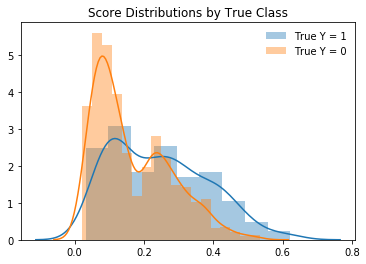

In [99]:
city = pickle.load(open("models/sklearn-glm.pkl", "rb"))
sns.distplot(city.predict_proba(X_test_pos)[:,1], label="True Y = 1")
sns.distplot(city.predict_proba(X_test_neg)[:,1], label="True Y = 0")
plt.legend(frameon=False)
plt.title("Score Distributions by True Class")
plt.show()

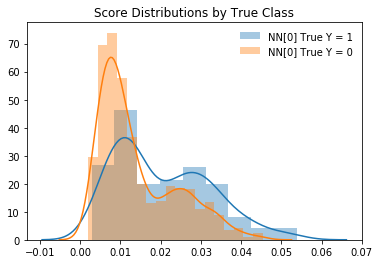

In [113]:
model = models[0]
crit_freq = crit_train.mean(axis=0)
sns.distplot(np.dot(model.predict(X_test_pos), crit_freq), label="NN[0] True Y = 1")
sns.distplot(np.dot(model.predict(X_test_neg), crit_freq), label="NN[0] True Y = 0")
plt.legend(frameon=False)
plt.title("Score Distributions by True Class (Raw x Freq)")
plt.show()

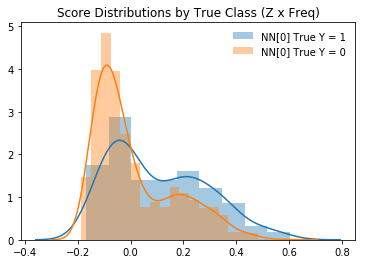

In [117]:
model = models[0]
crit_freq = crit_train.mean(axis=0)
sns.distplot(np.dot(predict_z(model, X_train, X_test_pos), crit_freq), label="NN[0] True Y = 1")
sns.distplot(np.dot(predict_z(model, X_train, X_test_neg), crit_freq), label="NN[0] True Y = 0")
plt.legend(frameon=False)
plt.title("Score Distributions by True Class (Z x Freq)")
plt.show()

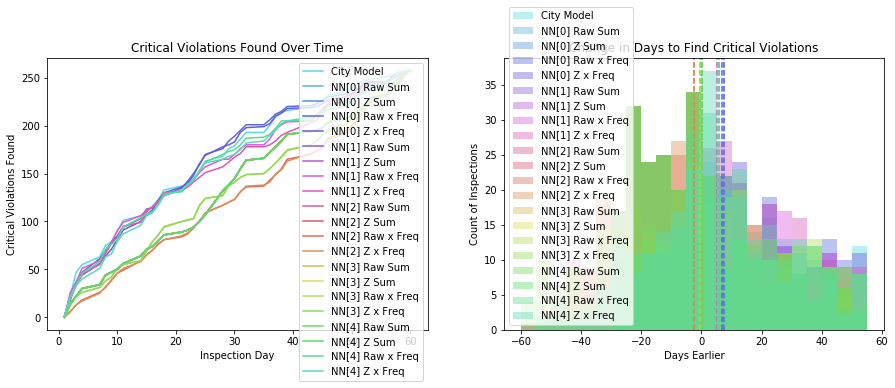

,Model,First Half,Mean Change,Std. Change
3,NN[0] Raw x Freq,0.721,7.407,25.422
4,NN[0] Z x Freq,0.702,6.977,25.875
0,City Model,0.690,7.438,25.156
19,NN[4] Raw x Freq,0.674,5.969,23.590
20,NN[4] Z x Freq,0.655,5.333,23.698
7,NN[1] Raw x Freq,0.640,5.926,25.661
8,NN[1] Z x Freq,0.636,5.209,25.954
15,NN[3] Raw x Freq,0.543,-0.484,29.199
16,NN[3] Z x Freq,0.539,-0.539,29.259
11,NN[2] Raw x Freq,0.465,-2.531,24.806


In [121]:
crit_freq = crit_train.mean(axis=0)
days = to_inspection_daynum(d_test[DATE])
all_models = [
    ("City Model", city.predict_proba(X_test)[:,1])
]
for i, model in enumerate(models):
    m1 = ("NN[{}] Raw Sum".format(i), model.predict(X_test).sum())
    m2 = ("NN[{}] Z Sum".format(i), predict_z(model, X_train, X_test).sum())
    m3 = ("NN[{}] Raw x Freq".format(i), np.dot(model.predict(X_test), crit_freq))
    m4 = ("NN[{}] Z x Freq".format(i), np.dot(predict_z(model, X_train, X_test), crit_freq))
    all_models.extend([m1, m2, m3 , m4])
compare_metrics(y_test, days, all_models)

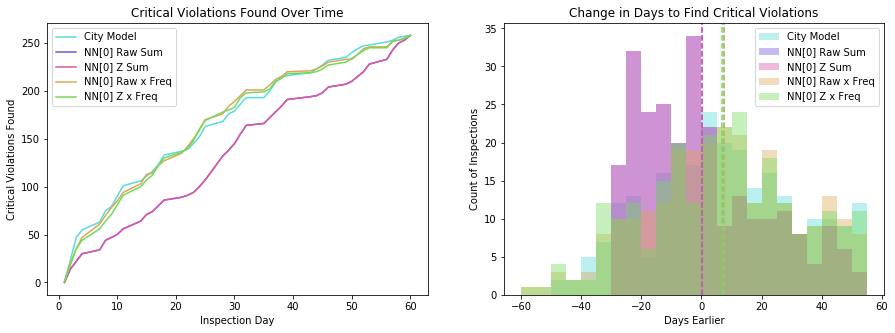

,Model,First Half,Mean Change,Std. Change
3,NN[0] Raw x Freq,0.721,7.407,25.422
4,NN[0] Z x Freq,0.702,6.977,25.875
0,City Model,0.690,7.438,25.156
1,NN[0] Raw Sum,0.457,0.182,21.065
2,NN[0] Z Sum,0.457,0.182,21.065


In [123]:
compare_metrics(y_test, days, all_models[0:5])

In [130]:
best_idx = 0
best_mid = model_ids[best_idx]
best_model = models[best_idx]
best_filename = "runs/divergence/model_{}.txt".format(best_mid)
print("Model {}".format(best_mid))
with open(best_filename, "r") as file:
    print(file.read())

Model 1553028756
Tuesday 03/19/19 03:52 PM
Epochs = 10
-----------
F1(Train) = 0.01244
Precision(Train) = 0.43750
Recall(Train) = 0.00631
F1(Test) = 0.03086
Precision(Test) = 0.36232
Recall(Test) = 0.01612
-----------
Predicts 0.19702% True on Train
Predicts 0.65150% True on Test
-----------
model = Sequential()
model.add(Dense(16, activation="linear", input_shape=(16,)))
model.add(Dense(16, activation="linear"))
model.add(Dense(14, activation="sigmoid"))



In [142]:
def get_logit_scorer(logit):
    def score_fn(X_test, crit_train):
        return logit.predict_proba(X_test)[:,1]
    return score_fn


def get_nn_rawxfreq_scorer(nn):
    def score_fn(X_test, crit_train):
        crit_freq = crit_train.mean(axis=0)
        scores = np.dot(nn.predict(X_test), crit_freq)
        return scores
    return score_fn


def show_metrics_best_split(score_models):
    BEST_SPLIT = 15762
    d_all = pd.read_csv("data/inspections.csv")
    d_train = d_all.query("{} <= {}".format(DATE, BEST_SPLIT))
    d_test = d_all.query("{} > {}".format(DATE, BEST_SPLIT))
    crit_train = get_crit_mat(d_train)
    crit_test = get_crit_mat(d_test)
    X_train = d_train[PREDICTORS]
    X_test = d_test[PREDICTORS]
    y_train = d_train[TARGET]
    y_test = d_test[TARGET]
    days = to_inspection_daynum(d_test[DATE])
    all_models = [
        (name, score_fn(X_test, crit_train))
        for name, score_fn in score_models
    ]
    return compare_metrics(y_test, days, all_models)

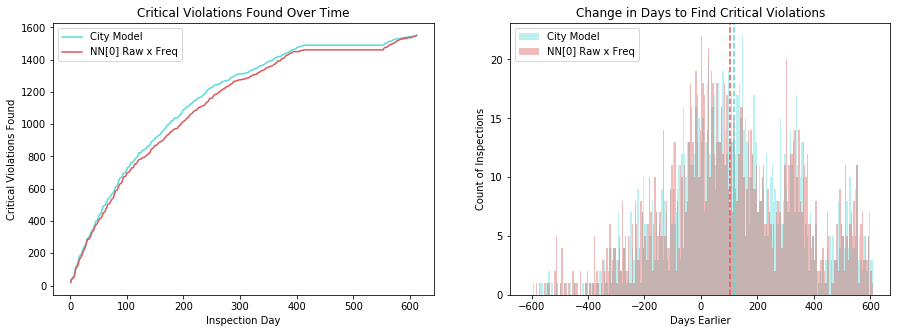

,Model,First Half,Mean Change,Std. Change
0,City Model,0.778,117.912,227.220
1,NN[0] Raw x Freq,0.732,104.498,239.199


In [143]:
show_metrics_best_split([
    ("City Model", get_logit_scorer(city)),
    ("NN[0] Raw x Freq", get_nn_rawxfreq_scorer(best_model))
])

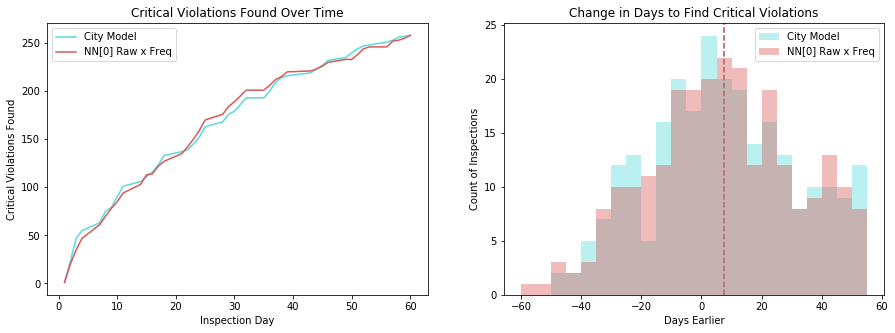

,Model,First Half,Mean Change,Std. Change
1,NN[0] Raw x Freq,0.721,7.407,25.422
0,City Model,0.690,7.438,25.156


In [144]:
compare_metrics(y_test, days, [all_models[0], all_models[3]])